# Danbooru Dataset
Let's download the dataset from Danbooru. For small size let's use the Kaggle 2018 dataset.

Download the images and metadata.

In [1]:
import os
import csv
import json
from pprint import pprint
import collections
import pandas as pd
import tensorflow as tf

import pickle

data_dir = os.path.join("..", "data")
# danbooru_img_dir = os.path.join(data_dir, "danbooru", "38986_61452_upload_danbooru-images", "danbooru-images", "0059")
danbooru_meta_dir = os.path.join(data_dir, "danbooru", "danbooru2019", "metadata")
danbooru_project_name = "project-small"

# Tfrecord
tfrecord_dir = os.path.join(data_dir, "preprocessed", danbooru_project_name)

# Metadata
output_metadata_dir = os.path.join(data_dir, "preprocessed", danbooru_project_name)
output_metadata_filename = "metadata.pkl"
output_metadata_path = os.path.join(output_metadata_dir, output_metadata_filename)
print(output_metadata_path)


# Make project name subfolder
if not os.path.exists(tfrecord_dir):
    print("Making folder: {}".format(tfrecord_dir))
    os.makedirs(tfrecord_dir)

..\data\preprocessed\project-small\metadata.pkl


## Preview Metadata

In [ ]:
%%time


def read_metadata(file_path, top_n=None):
    lines = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        line = file.readline()
        while line:
            line = json.loads(file.readline())
            lines[line['id']] = line
    return lines

            
def read_metadata_dict(file_path, top_n=None, filter_attributes=None, filter_tag=None):
    data = dict()
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            l = json.loads(line)
            if filter_attributes:
                l = {k: l.get(k, None) for k in filter_attributes}
                l['tags'] = [t['name'] for t in l['tags']]
                
            
            if filter_tag:
                if len([l for l in l['tags'] if l in filter_tag]):
                    data[l['id']] = l
            else:
                data[l['id']] = l
    return data

def read_metadata_list(file_path, top_n=None, filter_attributes=None, filter_tag=None):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            l = json.loads(line)
            if filter_attributes:
                l = {k: l.get(k, None) for k in filter_attributes}
                l['tags'] = [t['name'] for t in l['tags']]
                       
            if filter_tag:
                if len([l for l in l['tags'] if l in filter_tag]):
                    data.append(l)
            else:
                data.append(l)
    return data

def read_metadata_dir(file_dir, filter_attributes=None, filter_tag=None):
    # Walk through each
    json_path_list = [os.path.join(root, file) for root, subdirs, files in os.walk(file_dir) for file in files]
    json_dict = dict()
    for json_i, json_path in enumerate(json_path_list):
        print("Loading: {} of {}".format(str(json_i + 1).zfill(3), str(len(json_path_list)).zfill(3)))
        json_dict.update(read_metadata_dict(json_path, filter_attributes=filter_attributes, filter_tag=filter_tag))
        
    return json_dict
        
    

data_meta_raw = read_metadata_list(danbooru_meta_path, filter_attributes=['id', 'file_ext', 'tags'], filter_tag=["transparent_background"])
# data_meta = read_metadata_list(danbooru_meta_path, filter_attributes=['id', 'file_ext', 'tags'], filter_tag=["transparent_background", ""])
# data_meta = read_metadata_dict(danbooru_meta_path, filter_attributes=['id', 'file_ext', 'tags'])

single_filter_tag = "dragon_ball"
# data_meta = read_metadata_dir(danbooru_meta_dir, filter_attributes=['id', 'file_ext', 'tags', 'is_rating_locked'], filter_tag=[single_filter_tag])


In [ ]:
# # Read
# with open(output_metadata_path, 'rb') as f:
#     data_meta = pickle.load(f)

## Write text file for `rsync` option `--include-from=<txt-file>`
Output only the filtered files

In [ ]:
%%time
print("The length of data_meta is {}".format(len(data_meta.keys())))

rsync_instructions_dir = os.path.join("..", "data", "filters")
rsync_filename = "include_{tag}.txt".format(tag=single_filter_tag)
rsync_path = os.path.join(rsync_instructions_dir, rsync_filename)
print(rsync_path)

# Write out file
with open(rsync_path, 'w') as file:
    # look only at the original
    file.write("original" + "\n" + "original/*/" + "\n")
    for i, (k, v) in enumerate(data_meta.items()):
        include_filename = v['id'] + "." + v['file_ext']
        file.write(include_filename + "\n")

# Save Labels

In [ ]:
type(data_meta)

# Get tags from each image
tag_list = [tag for k, v in data_meta.items() for tag in v['tags']]

# Count each tags
tag_counts = collections.Counter(tag_list)

# Write to file
tags_path = os.path.join(tfrecord_dir, "tags.txt")
print("Writing outupt to: {}".format(tags_path))
with open(tags_path, "w") as f_tags:
    for i, tag in enumerate(tag_counts):
        if i == 0:
            f_tags.write(str(tag))
        else:
            f_tags.write("\n" + str(tag))


# TFRecord

## Create Label Mapping

In [ ]:
import numpy as np

print("There are n = {} labels".format(len(tag_counts)))
tag_all_array = np.array(list(tag_counts))
tag_all_array

# Mapping from tag to integer as ID
tag_map = dict(zip(tag_all_array, list(range(len(tag_all_array)))))


def map_tag_to_label(tag_array):
    labels = np.where(np.isin(tag_all_array,
                          tag_array), 1, 0).astype(np.float32)
    return labels


# label = map_tag_to_label(img_meta['tags'])
# print(label.shape)


# Save Metadata

In [ ]:
# Write
with open(output_metadata_path,"wb") as f:
    pickle.dump(data_meta, f)

In [ ]:
import glob
import matplotlib.pyplot as plt

print("data_meta has length n = {}".format(len(list(data_meta.keys()))))

# 
filter_key = list(data_meta.keys())[0]
img_meta = data_meta[filter_key]
# pprint(img_meta)
img_filename = str(img_meta['id']) + "." + img_meta['file_ext']
# print(img_filename)


# Image directory where rsync downloaded images from
image_dir = os.path.join(data_dir, "danbooru", "danbooru2019", "original")
print(image_dir)
print(os.path.join(image_dir, "*"))
image_list = glob.glob(os.path.join(image_dir, "*", "*"))
print(len(image_list))
print(image_list[0])
print(os.path.basename(image_list[0]))


# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename, height=512, width=512, resize=True):
    
    img_filename = os.path.basename(img_path)
    img_id, img_ext = os.path.splitext(img_filename)
    
    parts = tf.strings.split(filename, os.sep)

    image = tf.io.read_file(filename)
    if img_ext in [".jpg", ".jpeg"]:
        image = tf.image.decode_jpeg(image, channels=3)
    if img_ext in [".png"]:
        image = tf.image.decode_png(image, channels=3, dtype=tf.dtypes.uint8)
#     image = tf.image.resize(image, [height, width], preserve_aspect_ratio=True)
    if resize:
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize_with_pad(image=image, target_height=height, target_width=width)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return image


def plot_image(image, title=None):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    fig.show(image)

    
# Loop through image directory and match only within our data_meta
for img_i, img_path in enumerate(image_list):
    if img_i > 3:
        break
        
    img_filename = os.path.basename(img_path)
    img_id, img_ext = os.path.splitext(img_filename)
    print(img_filename)
    print(img_id)
    print(img_ext)
    
    # If not found in metadata continue
    if img_id not in data_meta.keys():
        continue
    
    img_meta = data_meta[img_id]
    print(img_meta)
    
    # Parse Image
    img = parse_image(img_path)
    print(img)
    tags = img_meta['tags']
    file_ext = img_meta['file_ext']
    label_id = [tag_map[tag] for tag in tags]
    
    plot_image(img, img_path)



C:\Users\serap\.conda\envs\danbooru\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


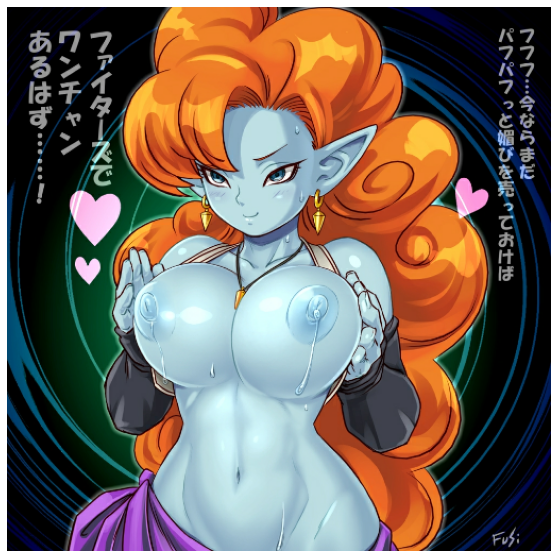

In [9]:
img_np = img.numpy()

img_shape = img_np.shape

img_flat = img_np.flatten()

img_reshape = np.reshape(img_flat, img_shape)

plot_image(img_reshape)

# Write an Example Ready for TFRecord

In [10]:
import pathlib

class DataUtil(object):
    def __init__(self):
        pass

    def int64_feature(self, value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


    def int64_list_feature(self, value):
      return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


    def bytes_feature(self, value):
      return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


    def bytes_list_feature(self, value):
      return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


    def float_list_feature(self, value):
      return tf.train.Feature(float_list=tf.train.FloatList(value=value))


dataset_util = DataUtil()

# def create_dataset(img, img_path, labels_text, label_id, file_ext):
    
#     if tf.is_tensor(img):
#         img = img.numpy()
        
#     labels_text = [tag.encode("utf8") for tag in labels_text]
    
#     image_shape = img.shape

#     feature_dict = {
#         'image/height': dataset_util.int64_feature(image_shape[0]),
#         'image/width': dataset_util.int64_feature(image_shape[1]),
#         'image/object/class/text': dataset_util.bytes_list_feature(labels_text),
#         'image/object/class/label': dataset_util.int64_list_feature(label_id),
#         'image/encoded': dataset_util.bytes_feature(img.tobytes()),
#         'image/filename': dataset_util.bytes_feature(img_path.encode('utf8')),
#         'image/format': dataset_util.bytes_feature(file_ext.encode('utf8')),
#     }

#     example = tf.train.Example(features=tf.train.Features(feature=feature_dict))

#     return example

def create_dataset(img, img_path, labels_text, label_id, file_ext):
    
    if tf.is_tensor(img):
        img = img.numpy()
        
    # Flatten
    img_flat = img.astype(dtype=np.uint8).flatten()
        
    labels_text = [tag.encode("utf8") for tag in labels_text]
    
    image_shape = img.shape

    feature_dict = {
        'image/height': dataset_util.int64_feature(image_shape[0]),
        'image/width': dataset_util.int64_feature(image_shape[1]),
        'image/depth': dataset_util.int64_feature(image_shape[2]),
        'image/object/class/text': dataset_util.bytes_list_feature(labels_text),
        'image/object/class/label': dataset_util.int64_list_feature(label_id),
        'image/encoded': dataset_util.int64_list_feature(img_flat.tolist()),
#         'image/encoded': dataset_util.bytes_list_feature(img_flat.encode('utf8')),
#         'image/encoded': dataset_util.bytes_feature(img.tobytes()),
        'image/filename': dataset_util.bytes_feature(img_path.encode('utf8')),
        'image/format': dataset_util.bytes_feature(file_ext.encode('utf8')),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))

    return example

def encode_example(img, img_path, labels_text, label_id):
    
    img_suffix = pathlib.Path(img_path).suffix

    img_path = str(pathlib.Path(img_path))

    image_string = open(img_path, 'rb').read()

    if tf.is_tensor(img):
        img = img.numpy()
        
    labels_text = [tag.encode("utf8") for tag in labels_text]
    
    image_shape = img.shape

    feature_dict = {
        'image/height': dataset_util.int64_feature(image_shape[0]),
        'image/width': dataset_util.int64_feature(image_shape[1]),
        'image/object/class/text': dataset_util.bytes_list_feature(labels_text),
        'image/object/class/label': dataset_util.int64_list_feature(label_id),
        'image/encoded': dataset_util.bytes_feature(image_string),
        'image/filename': dataset_util.bytes_feature(img_path.encode('utf8')),
        'image/format': dataset_util.bytes_feature(img_suffix.encode('utf8')),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))

    return example



def decode_example(example):
    read_features = {
        'image/width': tf.io.FixedLenFeature([], dtype=tf.int64),
        'image/height': tf.io.FixedLenFeature([], dtype=tf.int64),
        'image/object/class/text': tf.io.FixedLenFeature([], dtype=tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], dtype=tf.int64),
        'image/encoded': tf.io.FixedLenFeature([], dtype=tf.string),
        'image/filename': tf.io.FixedLenFeature([], dtype=tf.string),
        'image/format': tf.io.FixedLenFeature([], dtype=tf.string),
#         'image/id': tf.io.FixedLenFeature([], dtype=tf.int64),
    }

    # Extract features from serialized data
    read_example = tf.io.parse_single_example(serialized=example, features=read_features)
    return read_example


# # img = img.numpy()
# print(tf.is_tensor(img))
# print(type(img))
# print(img)
# print(img.shape)
# # print(img.tobytes())
# # dataset_util.bytes_feature(img.tobytes())

# # example = tf.train.Feature(bytes_list=tf.train.BytesList(value=img.tobytes()))
# example = tf.train.Feature(bytes_list=tf.train.BytesList(value=[img.tobytes()]))
print(tags)

print(label_id)
# example = create_dataset(
#     img=img, 
#     img_path=img_path, 
#     labels_text=tags, 
#     label_id=label_id, 
#     file_ext=file_ext)

example = encode_example(
    img=img, 
    img_path=img_path, 
    labels_text=tags, 
    label_id=label_id)
print("Example Made")

# Test Decode
# example_decode = decode_example(example)


['1girl', '>:)', 'bare_shoulders', 'black_background', 'blue_eyes', 'blue_skin', 'breast_squeeze', 'breasts', 'closed_mouth', 'collarbone', 'commentary_request', 'curly_hair', 'detached_sleeves', 'dragon_ball', 'dragon_ball_z', 'earrings', 'eyebrows_visible_through_hair', 'fingernails', 'fushisha_o', 'grey_vest', 'groin', 'hands_up', 'heart', 'jewelry', 'large_breasts', 'long_hair', 'looking_away', 'navel', 'necklace', 'nipples', 'open_clothes', 'open_vest', 'orange_hair', 'outline', 'pointy_ears', 'sash', 'seductive_smile', 'shiny', 'shiny_hair', 'signature', 'smile', 'solo', 'stomach', 'sweat', 'translation_request', 'tsurime', 'upper_body', 'v-shaped_eyebrows', 'very_long_hair', 'vest', 'wet', 'zangya']
[188, 1720, 205, 546, 208, 26, 413, 210, 939, 650, 972, 699, 700, 52, 246, 212, 940, 388, 942, 5466, 656, 945, 564, 219, 251, 356, 1081, 196, 625, 226, 1127, 4467, 1359, 2860, 540, 142, 4008, 956, 1034, 661, 199, 200, 1017, 259, 576, 964, 588, 179, 663, 180, 2598, 1360]
Example Made


# Decode Test TFrecord

In [11]:

# tfrecord_feature = {
#   'image/width': tf.io.FixedLenFeature([], dtype=tf.int64),
#   'image/height': tf.io.FixedLenFeature([], dtype=tf.int64),
#   'image/object/class/text': tf.io.VarLenFeature(dtype=tf.string),
#   'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64),
#   'image/encoded': tf.io.FixedLenFeature([], dtype=tf.string),
#   'image/filename': tf.io.FixedLenFeature([], dtype=tf.string),
#   'image/format': tf.io.FixedLenFeature([], dtype=tf.string),
# }


# example = tf.io.parse_single_example(example, tfrecord_feature)
# example['image/format']

# Write TFRecord

In [ ]:
import contextlib2


def open_sharded_output_tfrecords(exit_stack, base_path, num_shards, extension="tfrecord"):
    """Opens all TFRecord shards for writing and adds them to an exit stack.
    Args:
    exit_stack: A context2.ExitStack used to automatically closed the TFRecords
      opened in this function.
    base_path: The base path for all shards
    num_shards: The number of shards
    Returns:
    The list of opened TFRecords. Position k in the list corresponds to shard k.
    """
    tf_record_output_filenames = [
        '{}-{:05d}-of-{:05d}.{}'.format(base_path, idx, num_shards, extension)
        for idx in range(num_shards)
    ]

    tfrecords = [
        exit_stack.enter_context(tf.io.TFRecordWriter(file_name))
        for file_name in tf_record_output_filenames
    ]

    return tfrecords


# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename, height=512, width=512, resize=True):
    
    img_filename = os.path.basename(img_path)
    img_id, img_ext = os.path.splitext(img_filename)
    
    parts = tf.strings.split(filename, os.sep)

    image = tf.io.read_file(filename)
    if img_ext in [".jpg", ".jpeg"]:
        image = tf.image.decode_jpeg(image, channels=3)
    if img_ext in [".png"]:
        image = tf.image.decode_png(image, channels=3, dtype=tf.dtypes.uint8)
#     image = tf.image.resize(image, [height, width], preserve_aspect_ratio=True)
    if resize:
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize_with_pad(image=image, target_height=height, target_width=width)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return image


def create_dataset(img, img_path, labels_text, label_id, file_ext):
    
    if tf.is_tensor(img):
        img = img.numpy()
        
    # Flatten
    img_flat = img.astype(dtype=np.uint8).flatten()
        
    labels_text = [tag.encode("utf8") for tag in labels_text]
    
    image_shape = img.shape

    feature_dict = {
        'image/height': dataset_util.int64_feature(image_shape[0]),
        'image/width': dataset_util.int64_feature(image_shape[1]),
        'image/depth': dataset_util.int64_feature(image_shape[2]),
        'image/object/class/text': dataset_util.bytes_list_feature(labels_text),
        'image/object/class/label': dataset_util.int64_list_feature(label_id),
        'image/encoded': dataset_util.int64_list_feature(img_flat.tolist()),
#         'image/encoded': dataset_util.bytes_list_feature(img_flat.encode('utf8')),
#         'image/encoded': dataset_util.bytes_feature(img.tobytes()),
        'image/filename': dataset_util.bytes_feature(img_path.encode('utf8')),
        'image/format': dataset_util.bytes_feature(file_ext.encode('utf8')),
    }

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))

    return example


# TFRecord
def image_to_tfrecord_shards(image_path_list, tfrecord_dir, tfrecord_prefix, n_shards=8, skip_lt=None, skip_gt=None):
    
    tfrecord_output_path = os.path.join(tfrecord_dir, tfrecord_prefix)
    data_info_json_path = os.path.join(tfrecord_dir, "data_info.json")

    img_counter = 0
    
    print_per_n = 10
    
    tag_list = []
    
    # Start shards
    with contextlib2.ExitStack() as tf_record_close_stack:
        
        # List of shards
        output_tfrecords = open_sharded_output_tfrecords(
            tf_record_close_stack, tfrecord_output_path, n_shards)
        
        # Loop through image
        for img_i, img_path in enumerate(image_path_list):
            
            # Skip logic
            if skip_lt:
                if img_i <= skip_lt:
                    continue
            if skip_gt:
                if img_i >= skip_gt:
                    break
                    
            # img path
            img_filename = os.path.basename(img_path)
            img_id, img_ext = os.path.splitext(img_filename)

            # If not found in metadata continue
            if img_id not in data_meta.keys():
                continue
            
            if img_counter % print_per_n == 0:
                print("Working on image i = {}".format(img_counter))
            # Get information
            img_meta = data_meta[img_id]

            # Parse Image
            try:
                img = parse_image(img_path, resize=True)
                tags = img_meta['tags']
                file_ext = img_meta['file_ext']
                label_id = [tag_map[tag] for tag in tags]
            except:
                continue

            # Tags
            tag_list.extend(tags)
                
            # Make an example
            example = create_dataset(
                img=img, 
                img_path=img_path, 
                labels_text=tags, 
                label_id=label_id, 
                file_ext=file_ext)

            # Write tfrecord to shard
            shard_idx = img_counter % tfrecord_n_shards
            output_tfrecords[shard_idx].write(example.SerializeToString())
            img_counter += 1
        print("Made tfrecord with n = {}".format(img_counter))

    # Dataset Info
    tag_counts = dict(collections.Counter(tag_list))
    n_classes = len(tag_counts)
    tag_map = dict(zip(list(tag_counts), list(range(n_classes))))
    data_info = {
        'tag_counts': tag_counts,
        'n_classes': n_classes,
        'tag_map': tag_map,
    }
    with open(data_info_json_path, 'w') as outfile:
        json.dump(data_info, outfile)


tfrecord_n_shards = 8

dataset_name = "train"  # train, valid, test
tfrecord_dir_test = os.path.join(tfrecord_dir, dataset_name)
tfrecord_prefix_test = dataset_name
skip_lt = None
skip_gt = None
image_path_list = image_list[512:]
print("n images = {}".format(len(image_path_list)))

image_to_tfrecord_shards(
    image_path_list=image_path_list, 
    tfrecord_dir=tfrecord_dir_test, 
    tfrecord_prefix=dataset_name, 
    n_shards=8, 
    skip_lt=skip_lt, 
    skip_gt=skip_gt)

            
# tfrecord_dir_train = os.path.join(tfrecord_dir, "train")
# tfrecord_prefix_train = "train"
# tfrecord_path_train = os.path.join(tfrecord_dir_train, tfrecord_prefix_train)

# tfrecord_dir_test = os.path.join(tfrecord_dir, "test")
# tfrecord_prefix_test = "test"
# tfrecord_path_test = os.path.join(tfrecord_dir_test, tfrecord_prefix_test)

# output_tf_path = tfrecord_path_train
# output_tf_shards = tfrecord_n_shards

# if not os.path.exists(tfrecord_dir_train):
#     print("Making directory: {}".format(tfrecord_dir_train))
#     os.makedirs(tfrecord_dir_train)


# # Loop through image directory and match only within our data_meta
# img_counter = 1

# with contextlib2.ExitStack() as tf_record_close_stack:
#     output_tfrecords = open_sharded_output_tfrecords(
#         tf_record_close_stack, output_tf_path, output_tf_shards)

#     for img_i, img_path in enumerate(image_list):
#         if img_i >= 512:
#             break
#         img_filename = os.path.basename(img_path)
#         img_id, img_ext = os.path.splitext(img_filename)
#     #     print(img_filename)
#     #     print(img_id)
#     #     print(img_ext)

#         # If not found in metadata continue
#         if img_id not in data_meta.keys():
#             continue

#         print("Working on image i = {}".format(img_counter))
#         # Get information
#         img_meta = data_meta[img_id]

#         # Parse Image
#         try:
#             img = parse_image(img_path)
#             tags = img_meta['tags']
#             file_ext = img_meta['file_ext']
#             label_id = [tag_map[tag] for tag in tags]
#         except:
#             continue

#         # Make an example
#         example = create_dataset(
#             img=img, 
#             img_path=img_path, 
#             labels_text=tags, 
#             label_id=label_id, 
#             file_ext=file_ext)

#         # Write tfrecord to shard
#         shard_idx = img_counter % tfrecord_n_shards
#         output_tfrecords[shard_idx].write(example.SerializeToString())
#         img_counter += 1


n images = 7543
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i = 0
Working on image i

In [68]:
img.numpy().flatten().tolist()

[0,
 0,
 10,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 10,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 24,
 0,
 0,
 19,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 7,
 0,
 0,
 6,
 0,
 0,
 9,
 0,
 1,
 27,
 0,
 0,
 11,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 1,
 31,
 0,
 0,
 13,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 21,
 0,
 2,
 25,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 20,
 0,
 1,
 34,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


# Test and Preview TFRecord

['..\\data\\preprocessed\\project-small\\test\\test-00000-of-00008.tfrecord', '..\\data\\preprocessed\\project-small\\test\\test-00001-of-00008.tfrecord', '..\\data\\preprocessed\\project-small\\test\\test-00002-of-00008.tfrecord', '..\\data\\preprocessed\\project-small\\test\\test-00003-of-00008.tfrecord', '..\\data\\preprocessed\\project-small\\test\\test-00004-of-00008.tfrecord', '..\\data\\preprocessed\\project-small\\test\\test-00005-of-00008.tfrecord', '..\\data\\preprocessed\\project-small\\test\\test-00006-of-00008.tfrecord', '..\\data\\preprocessed\\project-small\\test\\test-00007-of-00008.tfrecord']
TensorSpec(shape=(), dtype=tf.string, name=None)
<class 'tensorflow.python.framework.ops.EagerTensor'>
image/width: 
	512
image/height: 
	512
image/depth: 
	3
image/object/class/text: 
	SparseTensor(indices=tf.Tensor(
[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]
 [18]
 [19]
 [20]
 [21]
 [22]
 [23]
 [24]], shape=(25, 1)

C:\Users\serap\.conda\envs\danbooru\lib\site-packages\ipykernel_launcher.py:52: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


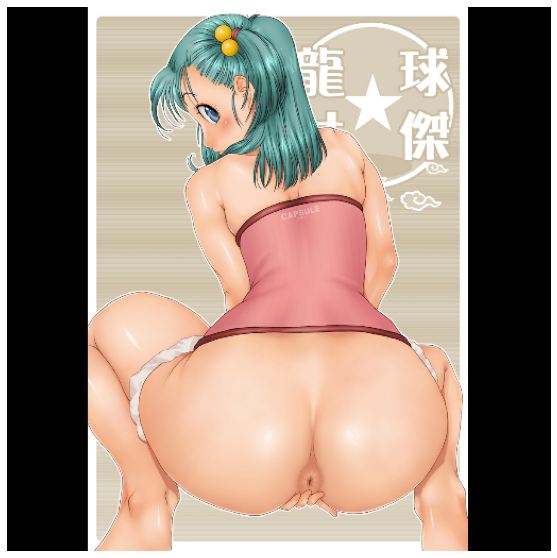

In [79]:
img_tfrecord_path_list = glob.glob(os.path.join(tfrecord_dir_test, "*.tfrecord"))
print(img_tfrecord_path_list)

# Make into tf.data
data_tf = tf.data.TFRecordDataset(
    img_tfrecord_path_list, compression_type=None, buffer_size=None, num_parallel_reads=None
)


tfrecord_feature = {
  'image/width': tf.io.FixedLenFeature([], dtype=tf.int64),
  'image/height': tf.io.FixedLenFeature([], dtype=tf.int64),
  'image/depth': tf.io.FixedLenFeature([], dtype=tf.int64),
  'image/object/class/text': tf.io.VarLenFeature(dtype=tf.string),
  'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64),
  'image/encoded': tf.io.VarLenFeature(dtype=tf.int64),
  'image/filename': tf.io.FixedLenFeature([], dtype=tf.string),
  'image/format': tf.io.FixedLenFeature([], dtype=tf.string),
}


print(data_tf.element_spec)
for element in data_tf.take(1):
    pprint(type(element))
    example = tf.io.parse_single_example(element, tfrecord_feature)

    for k in tfrecord_feature.keys():
        if k == 'image/encoded':
            continue
        tf.print("{}: \n\t{}".format(k, example[k]))

    h = example['image/height']
    w = example['image/height']
    d = example['image/depth']
    img = example['image/encoded']
#     img = np.frombuffer(img, dtype=np.int8, count=-1)
    # img = tf.image.decode_jpeg(example['image/encoded'])
#     height, width, depth = 
    print("====img")
    print(img)
    print(img.shape)
    img_reshape = tf.sparse.reshape(img, (h, w, d))
    img_reshape = tf.sparse.to_dense(img_reshape)
    plot_image(img_reshape)
#     print(np.min(img))
#     print(np.max(img))
#     img_np = cv2.imdecode(img, cv2.IMREAD_COLOR) # cv2.IMREAD_COLOR in OpenCV 3.1
#     print(img_np)
    # print(img[:10])
    # img = cv2.imdecode(np.frombuffer(img, np.uint8), -1)
    # print(img.shape)
    # print(tf.cast(element['image/height'], tf.int32))


# Write tf.data

In [19]:
# class custom_data_generator(object):
#     def __init__(self, n_classes, image_list, label_list):
#         self.n_classes = n_classes
#         self.image_list = image_list
#         self.label_list = label_list
#     def dataset_generator(self):
#         n_image = len(self.image_list)
#         n_label = len(self.label_list)
#         assert n_image == n_label, "image_list and label_list must be of same length"
#         for i in range(n_image):
#             record = {"image": self.image_list[i], "label": self.label_list[i]}
#             yield record

# data_gen = custom_data_generator(n_classes=NUM_CLASSES, image_list=image_list, label_list=label_list)

# dataset = tf.data.Dataset.from_generator(
#     data_gen.dataset_generator,
#     output_types={"image": tf.uint8, "label": tf.int64},
#     output_shapes={'image': (None, None, 3), 'label': ()}
# )


def map_tag_to_label(tag_array):
    labels = np.where(np.isin(tag_all_array,
                          tag_array), 1, 0).astype(np.float32)
    return labels

# map_tag_to_label(np.array([0, 1, 3, 5]))
def map_label_to_multihot(tag_array, n_classes):
    class_array = np.array(list(range(n_classes)))
    labels = np.where(np.isin(class_array, tag_array), 1, 0).astype(np.float32)
    return labels

map_label_to_multihot(np.array([0, 1, 3, 5]), 10)

array([1., 1., 0., 1., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [25]:
image_list = []
label_list = []
img_counter = 0

image_list_raw = glob.glob(os.path.join(image_dir, "*", "*"))
print("image_list_raw = {}".format(len(parse_image)))

def map_tag_to_label(tag_array):
    labels = np.where(np.isin(tag_all_array,
                          tag_array), 1, 0).astype(np.float32)
    return labels

for img_i, img_path in enumerate(image_list_raw):
    if img_counter < 512:
        img_counter += 1
        continue
    if img_counter >= (512 + 128):
        print("breaking img_counter = {}".format(img_counter))
        break
        
    img_filename = os.path.basename(img_path)
    img_id, img_ext = os.path.splitext(img_filename)

    # If not found in metadata continue
    if img_id not in data_meta.keys():
        continue

    print("Working on image i = {}".format(img_counter))
    # Get information
    img_meta = data_meta[img_id]

    # Parse Image
    try:
        img = parse_image(img_path, resize=True)
        tags = img_meta['tags']
        file_ext = img_meta['file_ext']
        label_id = [tag_map[tag] for tag in tags]
    except:
        continue
    
    if img.shape[-1] != 3:
        continue
    
    # Append
    image_list.append(img)
    label_list.append(label_id)
    
    img_counter += 1

print("image_list = {}".format(len(image_list)))
print("label_list = {}".format(len(label_list)))

image_list_raw = 8055
Working on image i = 512
Working on image i = 513
Working on image i = 513
Working on image i = 514
Working on image i = 515
Working on image i = 516
Working on image i = 517
Working on image i = 518
Working on image i = 519
Working on image i = 520
Working on image i = 521
Working on image i = 522
Working on image i = 523
Working on image i = 524
Working on image i = 525
Working on image i = 526
Working on image i = 527
Working on image i = 528
Working on image i = 529
Working on image i = 530
Working on image i = 531
Working on image i = 532
Working on image i = 533
Working on image i = 534
Working on image i = 535
Working on image i = 536
Working on image i = 537
Working on image i = 538
Working on image i = 539
Working on image i = 540
Working on image i = 541
Working on image i = 541
Working on image i = 542
Working on image i = 543
Working on image i = 544
Working on image i = 545
Working on image i = 546
Working on image i = 547
Working on image i = 548
Wor

# Write Images and Labels

In [27]:
n_classes = len(tag_map.keys())
print(n_classes)

class custom_data_generator(object):
    def __init__(self, n_classes, image_list, label_list):
        self.n_classes = n_classes
        self.image_list = image_list
        self.label_list = label_list
    def dataset_generator(self):
        n_image = len(self.image_list)
        n_label = len(self.label_list)
        assert n_image == n_label, "image_list and label_list must be of same length"
        for i in range(n_image):
            record = {"image": self.image_list[i], "label": self.label_list[i]}
            yield record

# Instance
data_gen = custom_data_generator(n_classes=n_classes, image_list=image_list, label_list=label_list)

# Make tf.data
dataset = tf.data.Dataset.from_generator(
    data_gen.dataset_generator,
    output_types={"image": tf.uint8, "label": tf.int64},
    output_shapes={'image': (None, None, 3), 'label': (None)}
)

# Preview
for i, d in enumerate(dataset):
    if i > 0:
        break
    print(d)

# Write
dataset_name = "test"  # train, test, valid
generate_dir = os.path.join(tfrecord_dir, dataset_name)
generate_filename = "generator_{}.pkl".format(dataset_name)
generate_path = os.path.join(generate_dir, generate_filename)
print(generate_path)

image_list_path = os.path.join(generate_dir, "image_list_{}.pkl".format(dataset_name))
label_list_path = os.path.join(generate_dir, "label_list_{}.pkl".format(dataset_name))

# Write
with open(image_list_path,"wb") as f:
    pickle.dump(image_list, f)
with open(label_list_path,"wb") as f:
    pickle.dump(label_list, f)

15096
{'image': <tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(18,), dtype=int64, numpy=
array([ 188,  208,  210, 1057, 2176,  939,  972,   52,  246, 1066, 1067,
  

C:\Users\serap\.conda\envs\danbooru\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


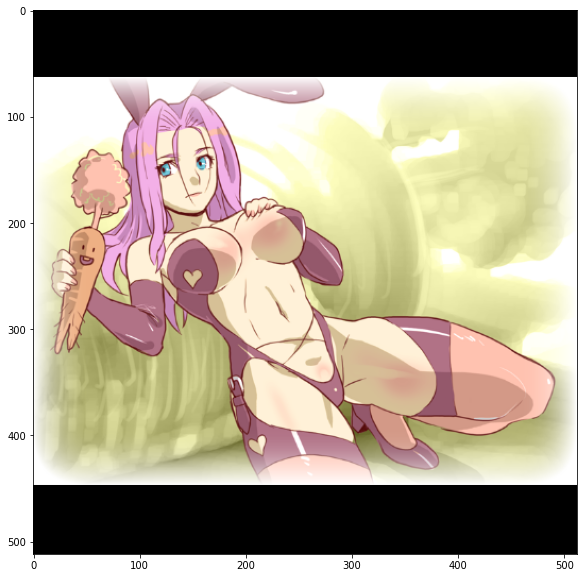

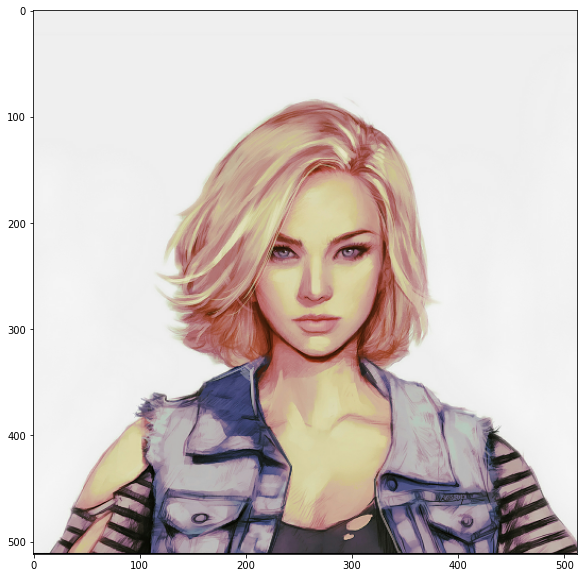

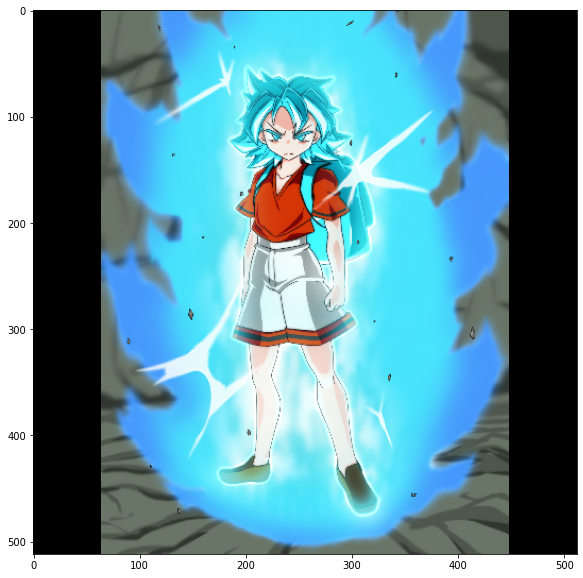

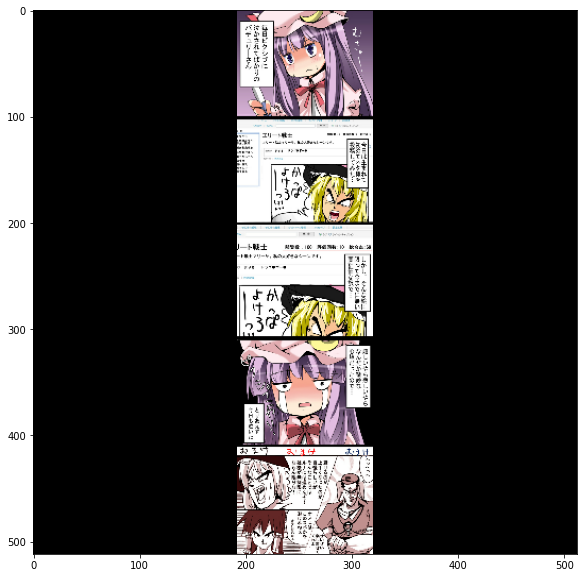

In [28]:
for i, img in enumerate(image_list):
    
    fig, axes = plt.subplots(1, 1, figsize=(10, 10), squeeze=True)
    axes.imshow(img)
    fig.show()
    
    if i > 2:
        break
    
    if img.shape != (512, 512, 3):
        print(i)
        print(img.shape)
        break
        
#     if i > 3:
#         break

# Preview

In [83]:

tfrecord_dir_test = os.path.join(tfrecord_dir, "test")
tfrecord_prefix_test = "test"
tfrecord_path_test = os.path.join(tfrecord_dir_test, tfrecord_prefix_test)
tfrecord_path_test_single = os.path.join(tfrecord_dir_test, "test-00000-of-00002.tfrecord")

data_test = tf.data.TFRecordDataset(tfrecord_path_test_single)

In [84]:
for i, d in enumerate(data_test):
    if i > 0:
        break
    print(d)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [85]:



def _parse_function(example_proto):
    feature_description = {
        'feature0': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'feature1': tf.io.FixedLenFeature([], tf.int64, default_value=0),
        'feature2': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'feature3': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    }
    # Parse the input `tf.Example` proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_description)


['OVERLOADABLE_OPERATORS',
 '_USE_EQUALITY',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__complex__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__iter__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_add_consumer',


In [24]:
import cv2

def load_image(image_path):
    img = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
    
    if img is None:
        print("Image {} returns None".format(image_path))
        return None
    
    # Add alpha channel if not PNG
    if img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    return img

image_path = "G:/AI/shazam/tfod/data/danbooru/rsync_download/original/0961/2524961.gif"
# test = load_image()
img = cv2.imread(str(image_path), cv2.IMREAD_UNCHANGED)
type(img)

NoneType

# Tags

In [28]:
# tag_list = [tag['name'] for img in data_meta for tag in img['tags']]
tag_list = [tag for img in data_meta for tag in img['tags']]
tag_counts = collections.Counter(tag_list)

In [32]:
tag_counts['transparent_background']
tag_counts

AttributeError: 'Counter' object has no attribute 'sort'

In [38]:
tag_list_unique = tag_counts.keys()
print(len(tag_list_unique))

t_filter = []
for t in tag_counts.keys():
    if "rating" in t:
        t_filter.append(t)
# tag_list_unique = list(tag_list_unique)
# tag_list_unique.sort()
# tag_list_unique
t_filter

147830


['rating',
 'concentrating',
 'operatingtethan',
 'operating_table',
 'decorating',
 'grating']

In [65]:
t_filter.sort()
t_filter

['alana_(transformers)',
 'alpha_transparency',
 "asashio_(flowering_season's_transfer_student)_(azur_lane)",
 'beachcomber_(transformers)',
 'black_sister_(chaos_transformation)',
 'canislatrans',
 'carly_(transformers)',
 'check_translation',
 'devastator_(transformers)',
 'dirge_(transformers)',
 'eagle_transporter',
 'esu_(transc)',
 'fake_translation',
 'fake_transparency',
 'ginrai_(transformers)',
 'hard_translated',
 'hard_translated_(non-english)',
 'hound_(transformers)',
 'instant_transmission',
 'juliona_trans',
 'karmatron_y_los_transformables',
 'knockout_(transformers)',
 'lost_abyssal_transport_ship_(warship_girls_r)',
 'luna_transporter',
 'mazinger_z_vs._transformers',
 'overlord_(transformers)',
 'partially_translated',
 'pontiac_firebird_trans-am',
 'poorly_translated',
 'q-transformers',
 'radio_transceiver',
 'raiden_(transformers)',
 'red_(transistor)',
 'reverse_translation',
 'satori_(transient_wind)',
 'semi-transparent',
 'shelke_the_transparent',
 'shockwave

# Filter
Let's filter on specific tags

In [82]:
import yaml
instruction = yaml.load(open("../data/generator/instructions/generate_data_pre_augmented.yaml"), Loader=yaml.FullLoader)
instruction


def class_to_image_paths(image_yaml_list, ext_valid=['jpg', 'png', 'jpeg'], class_key="class"):
    """
    Desc:
        Read instructions and return dictionary that allows looping through images
    """
    import random
    
    def generator_shuffler(img_list):
        """
        Generator that shuffles the list given while being infinite
        """
        while True:
            random.shuffle(img_list)
            yield from img_list
    
    class_dict = dict()
    for img in image_yaml_list:
        # Walk through each directory and get files
        images_file = [os.path.join(root, file) for root, subdirs, files in os.walk(os.path.join("..", img['path'])) for file in files if os.path.splitext(file)[-1].replace(".", "") in ext_valid]
        img['img_paths'] = images_file
        img['generator'] = generator_shuffler(images_file)
        class_dict[img[class_key]] = img
    return class_dict



class_img_dir = class_to_image_paths(instruction['foreground']['images'])
print(class_img_dir.keys())
print(len(class_img_dir['anime_transparent_background']['img_paths']))

dict_keys(['kirby', 'pikachu', 'ss', 'swastika', 'anime_transparent_background'])
36038


In [78]:

pprint(class_img_dir['kirby'])
pprint(class_img_dir['pikachu'])

j_list = []
for i, j in enumerate(class_img_dir['kirby']['generator']):
    print(j)
    j_list.append(j)
    if i > 30:
        break

{'class': 'kirby',
 'filename': 'kirby',
 'generator': <generator object class_to_image_paths.<locals>.generator_shuffler at 0x0000024352754848>,
 'img_paths': ['..\\data/generator/transform/kirby\\kirby_00001.png',
               '..\\data/generator/transform/kirby\\kirby_00002.png',
               '..\\data/generator/transform/kirby\\kirby_00003.png',
               '..\\data/generator/transform/kirby\\kirby_00004.png',
               '..\\data/generator/transform/kirby\\kirby_00005.png',
               '..\\data/generator/transform/kirby\\kirby_00006.png'],
 'multilabel': ['safe'],
 'path': 'data/generator/transform/kirby',
 'type': 'dir'}
{'class': 'pikachu',
 'filename': 'pikachu',
 'generator': <generator object class_to_image_paths.<locals>.generator_shuffler at 0x00000243527544C8>,
 'img_paths': ['..\\data/generator/transform/pikachu\\pikachu_00001.png',
               '..\\data/generator/transform/pikachu\\pikachu_00002.png',
               '..\\data/generator/transform/pikach

In [65]:
print(j_list[:10])
print(j_list[10:20])
print(j_list[20:30])

[4, 9, 0, 8, 7, 1, 2, 6, 5, 3]
[3, 7, 1, 5, 6, 9, 8, 2, 0, 4]
[0, 6, 8, 1, 2, 3, 4, 9, 5, 7]


In [92]:
background_img_dir = class_to_image_paths(instruction['background']['images'], class_key="filename")
pprint(background_img_dir)
background_images = []
for k, v in background_img_dir.items():
    for img_path in v['img_paths']:
        item = v.copy()
        del item['img_paths']
        item['path'] = img_path
        background_images.append(item)
        
pprint(background_images)

{'car_front_right_ford_mustang.jpg': {'filename': 'car_front_right_ford_mustang.jpg',
                                      'generator': <generator object class_to_image_paths.<locals>.generator_shuffler at 0x0000024354689D48>,
                                      'img_paths': ['..\\data/generator/transform/car_front_right_ford_mustang\\car_front_right_ford_mustang_00001.png',
                                                    '..\\data/generator/transform/car_front_right_ford_mustang\\car_front_right_ford_mustang_00002.png'],
                                      'path': 'data/generator/transform/car_front_right_ford_mustang',
                                      'plot_areas': [{'bottom_right': [650,
                                                                       250],
                                                      'top_left': [400, 150]}]},
 'car_side_left_vw_golf': {'filename': 'car_side_left_vw_golf',
                           'generator': <generator object class_

In [99]:
1.212*1400/60/60

0.47133333333333327

# Predictions

../../DeepDanbooru/data/tfod/images\predict_007.png
(227, 266, 4)
../../DeepDanbooru/data/tfod/images\predict_008.png
(274, 180, 4)
../../DeepDanbooru/data/tfod/images\predict_008_002.png
(90, 43, 4)
../../DeepDanbooru/data/tfod/images\predict_009.png
(522, 196, 4)
../../DeepDanbooru/data/tfod/images\predict_010.png
(513, 186, 4)
../../DeepDanbooru/data/tfod/images\predict_011.png
(240, 133, 4)
../../DeepDanbooru/data/tfod/images\predict_012.png
(240, 57, 4)
../../DeepDanbooru/data/tfod/images\predict_013_001.png
(227, 109, 4)
../../DeepDanbooru/data/tfod/images\predict_013_002.png
(151, 181, 4)
../../DeepDanbooru/data/tfod/images\predict_014.png
(350, 290, 4)
../../DeepDanbooru/data/tfod/images\predict_015.png
(873, 962, 4)
../../DeepDanbooru/data/tfod/images\predict_016.png
(847, 1029, 4)
../../DeepDanbooru/data/tfod/images\predict_017.png
(252, 180, 4)
====== predict_007.png
====== predict_008.png
====== predict_008_002.png
====== predict_009.png
====== predict_010.png
====== predic

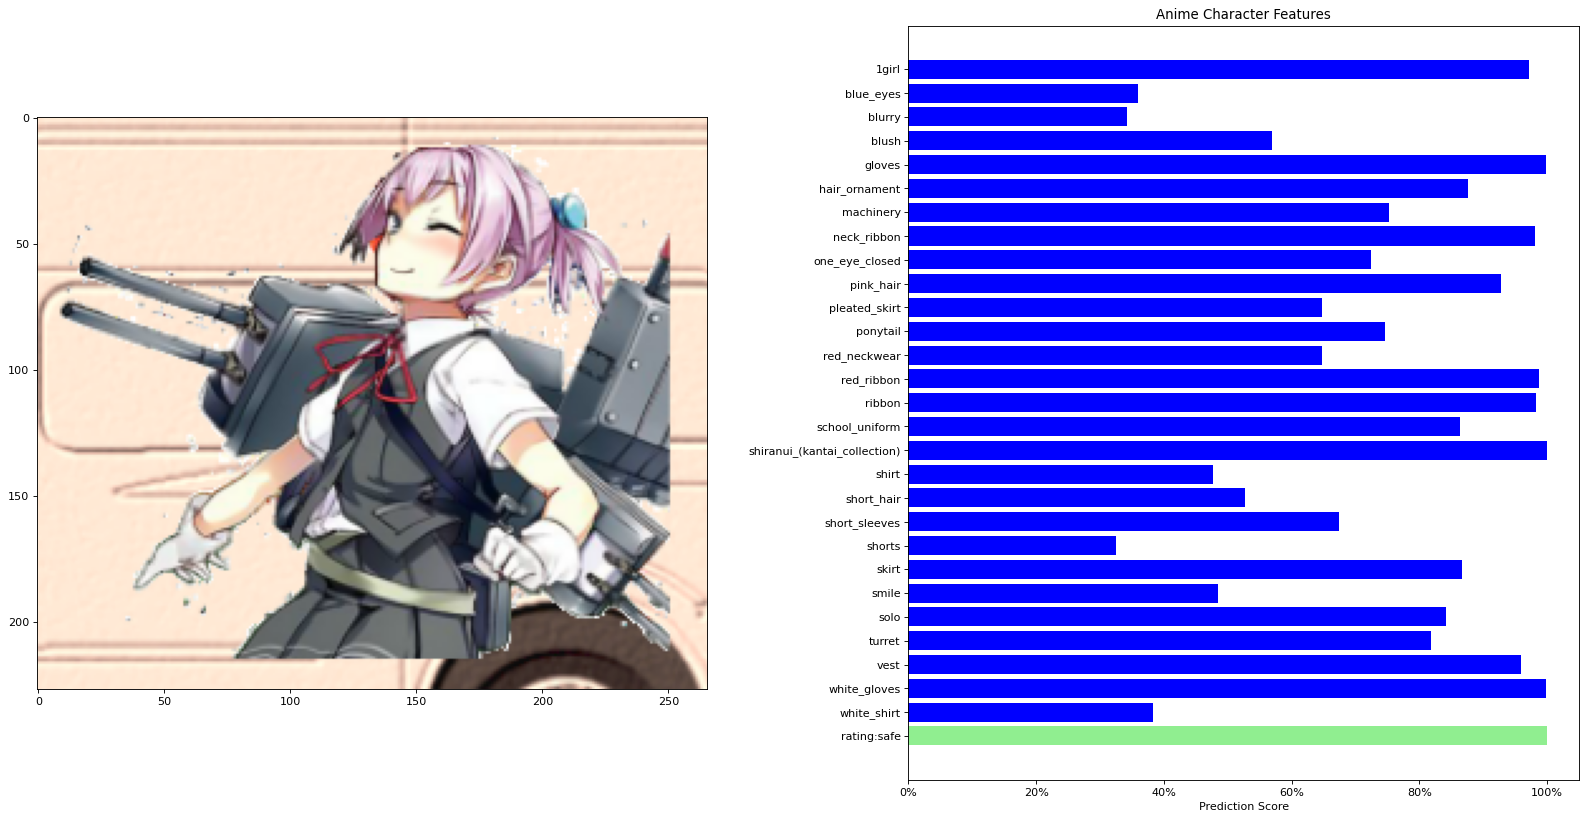

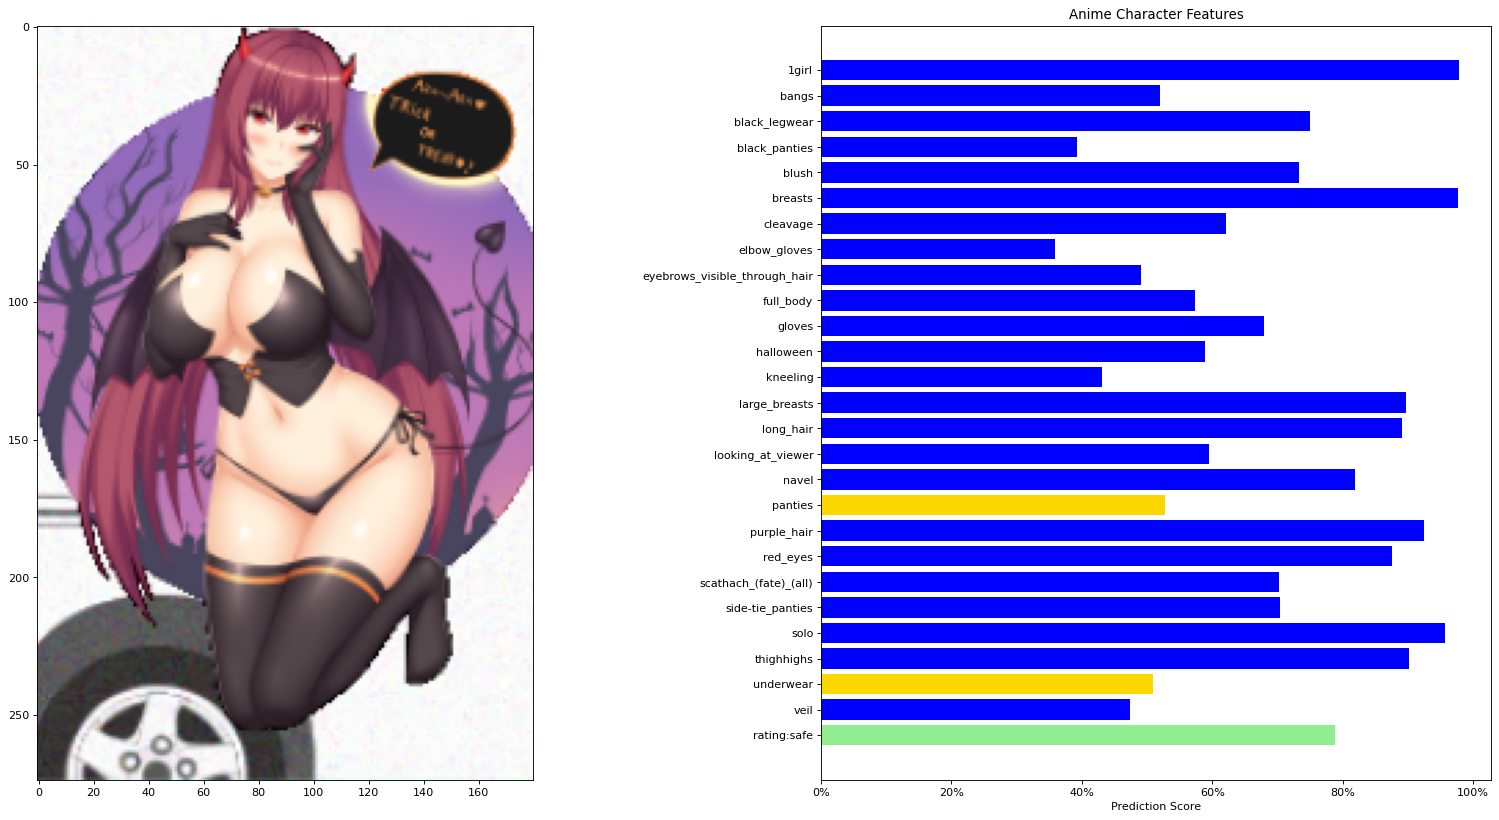

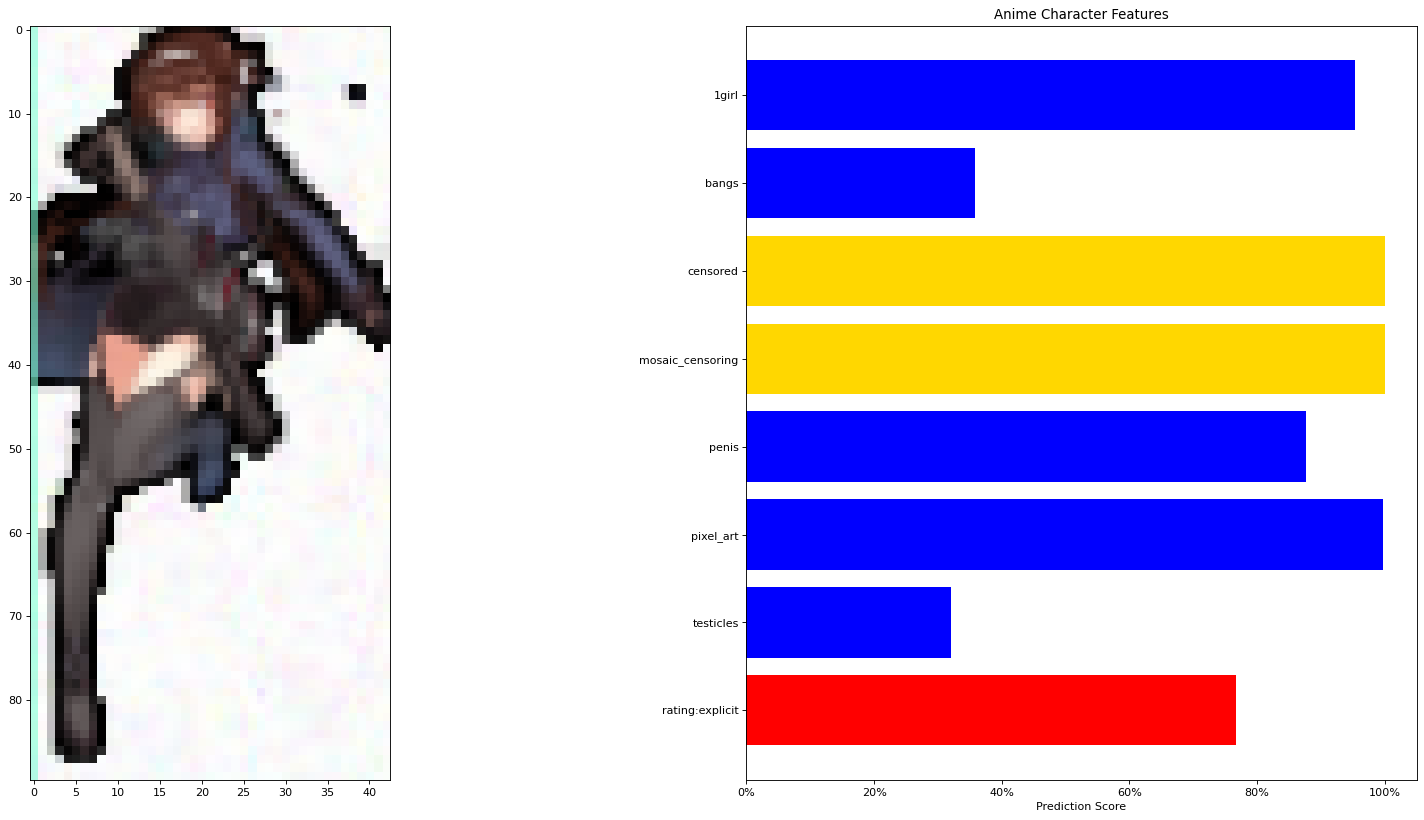

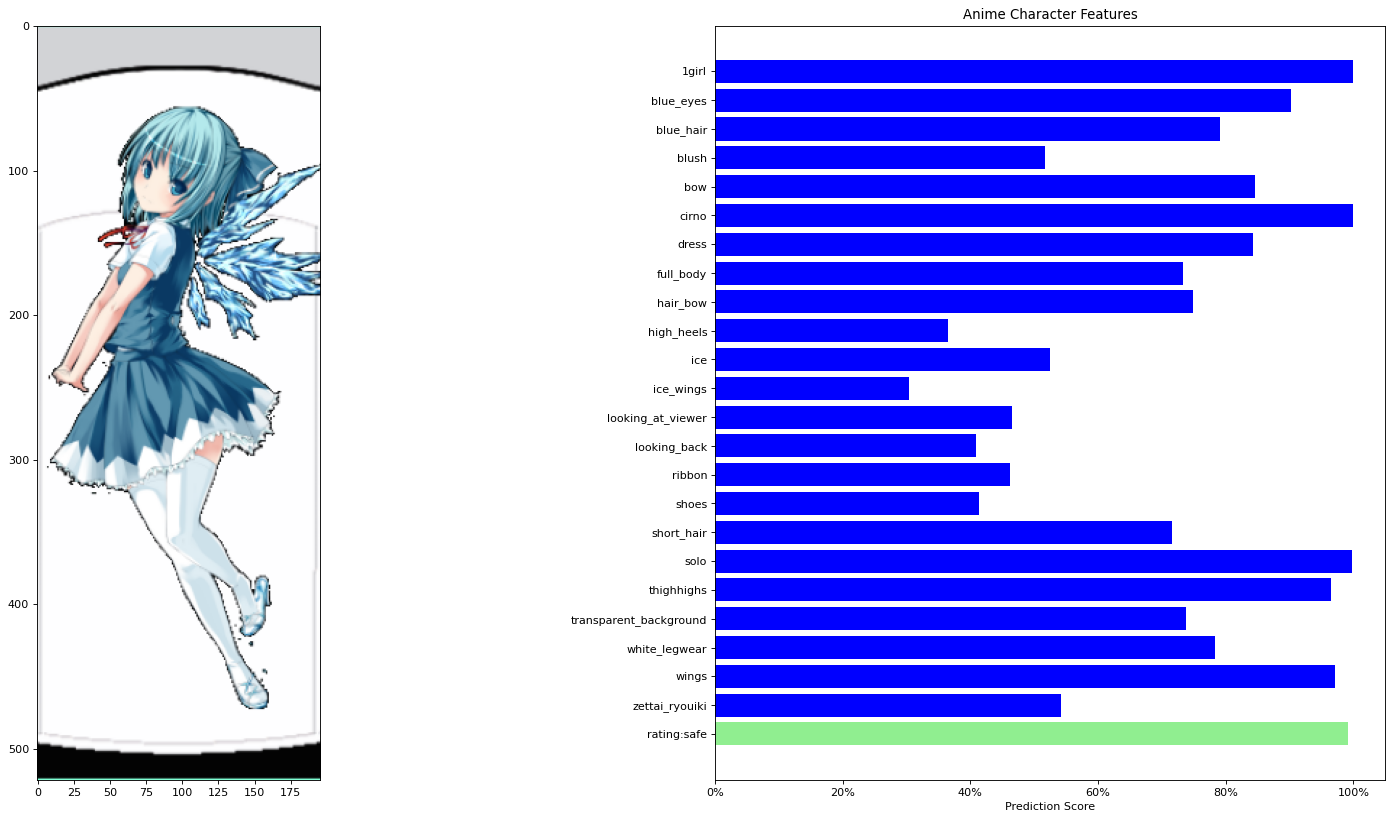

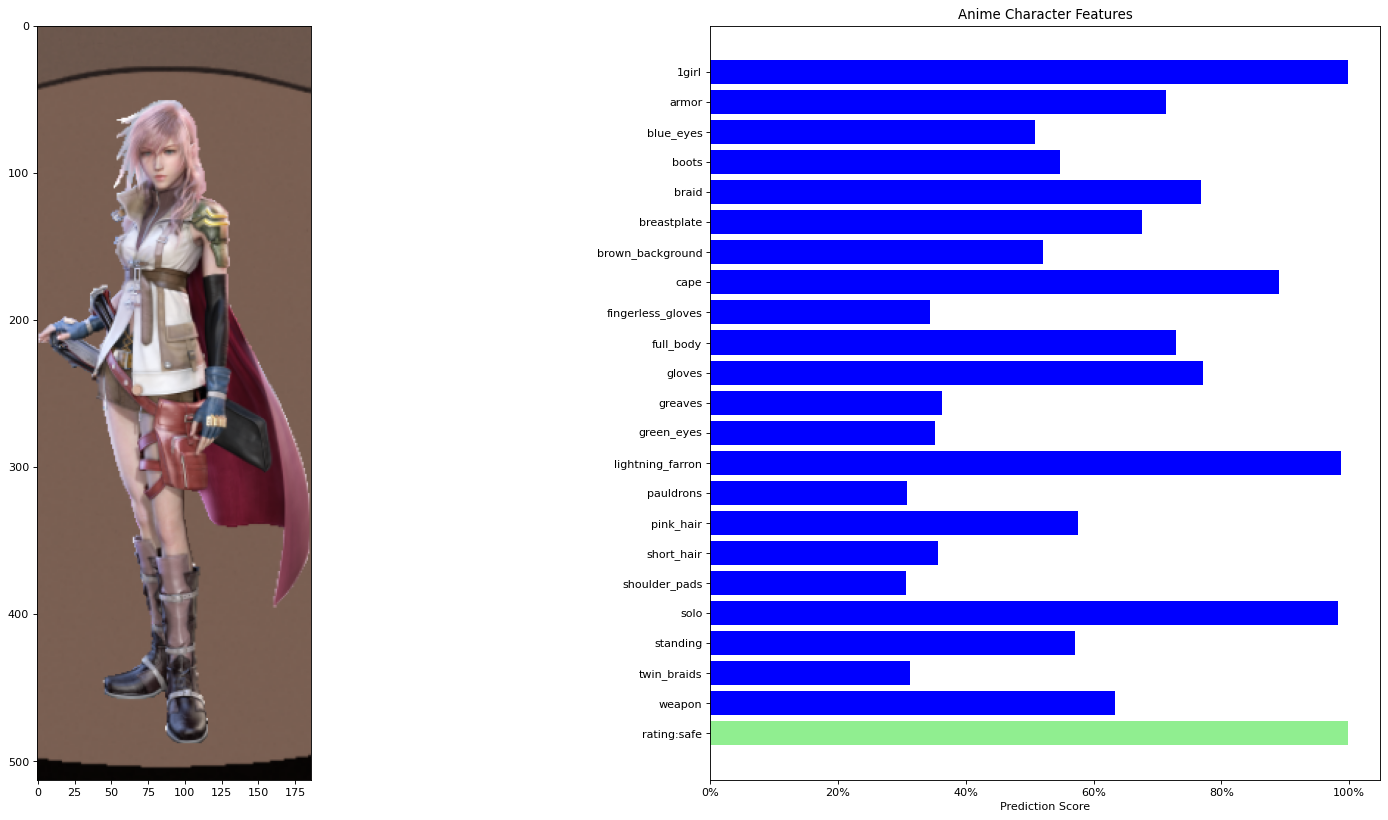

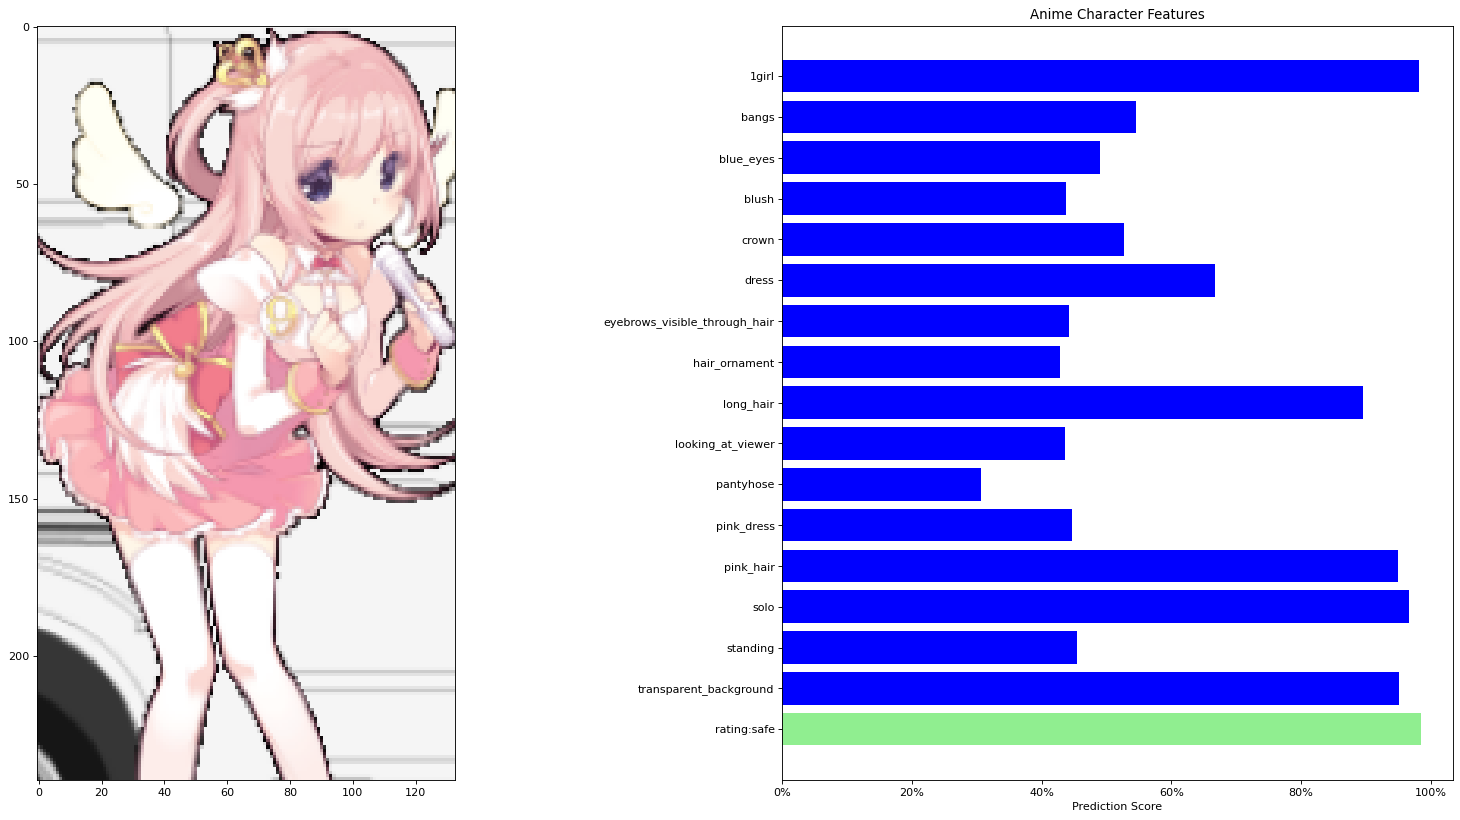

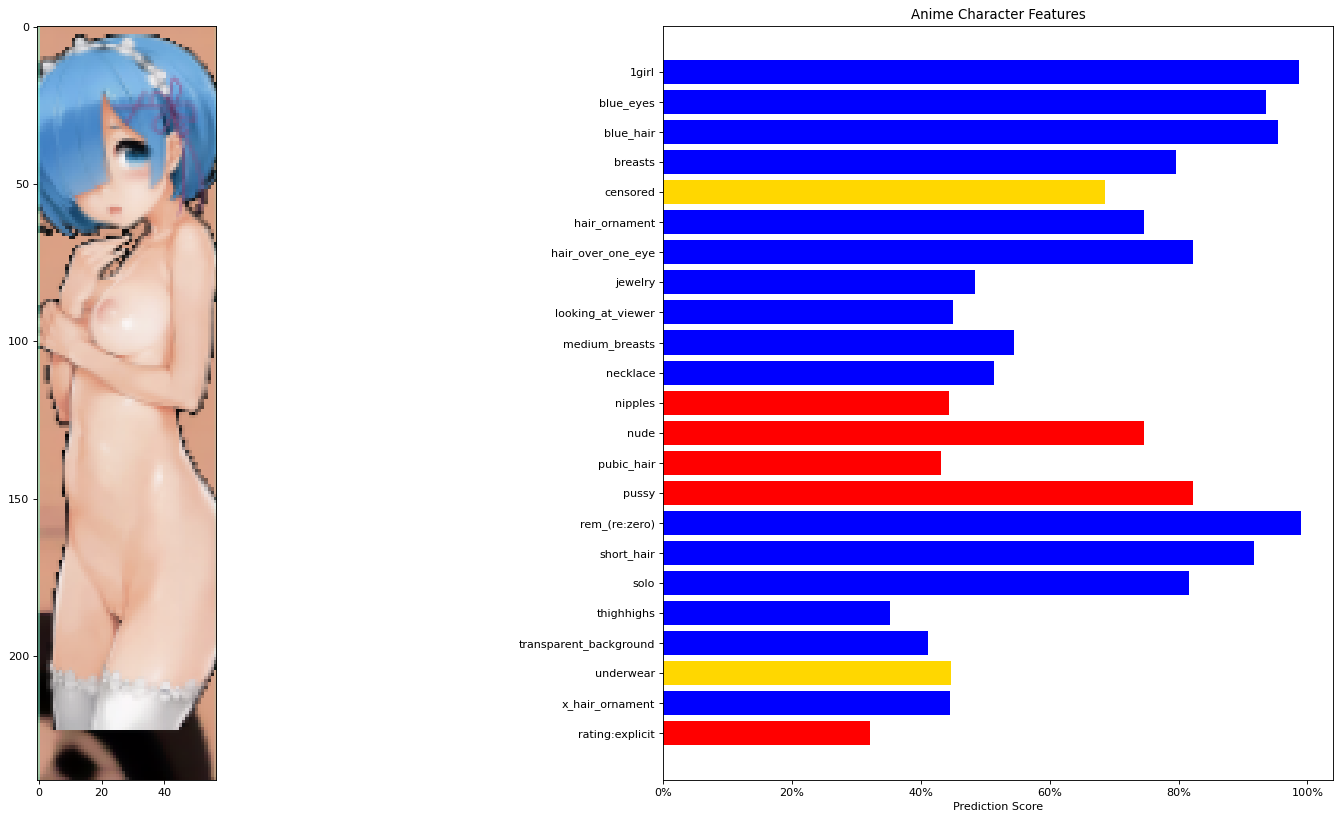

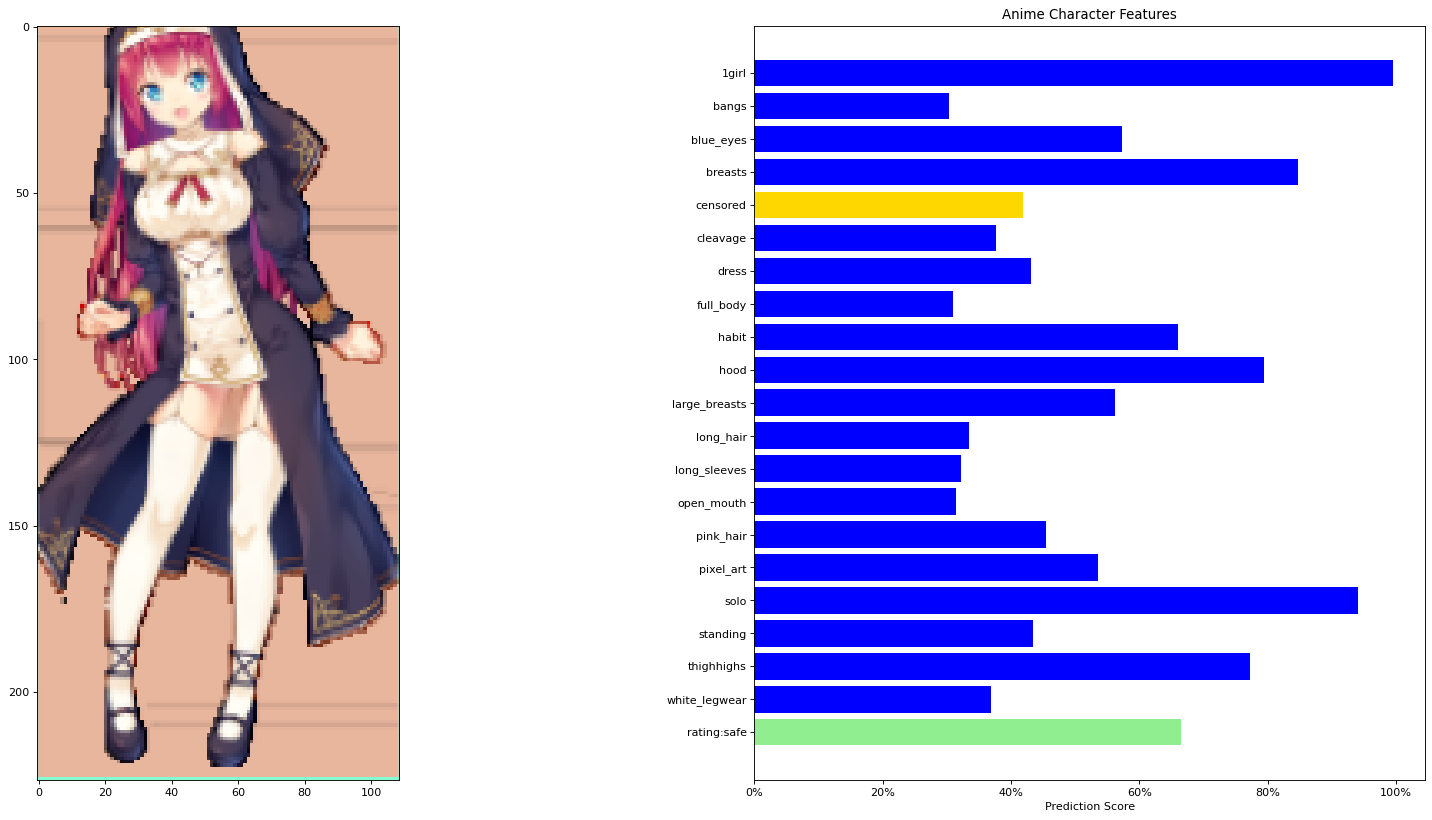

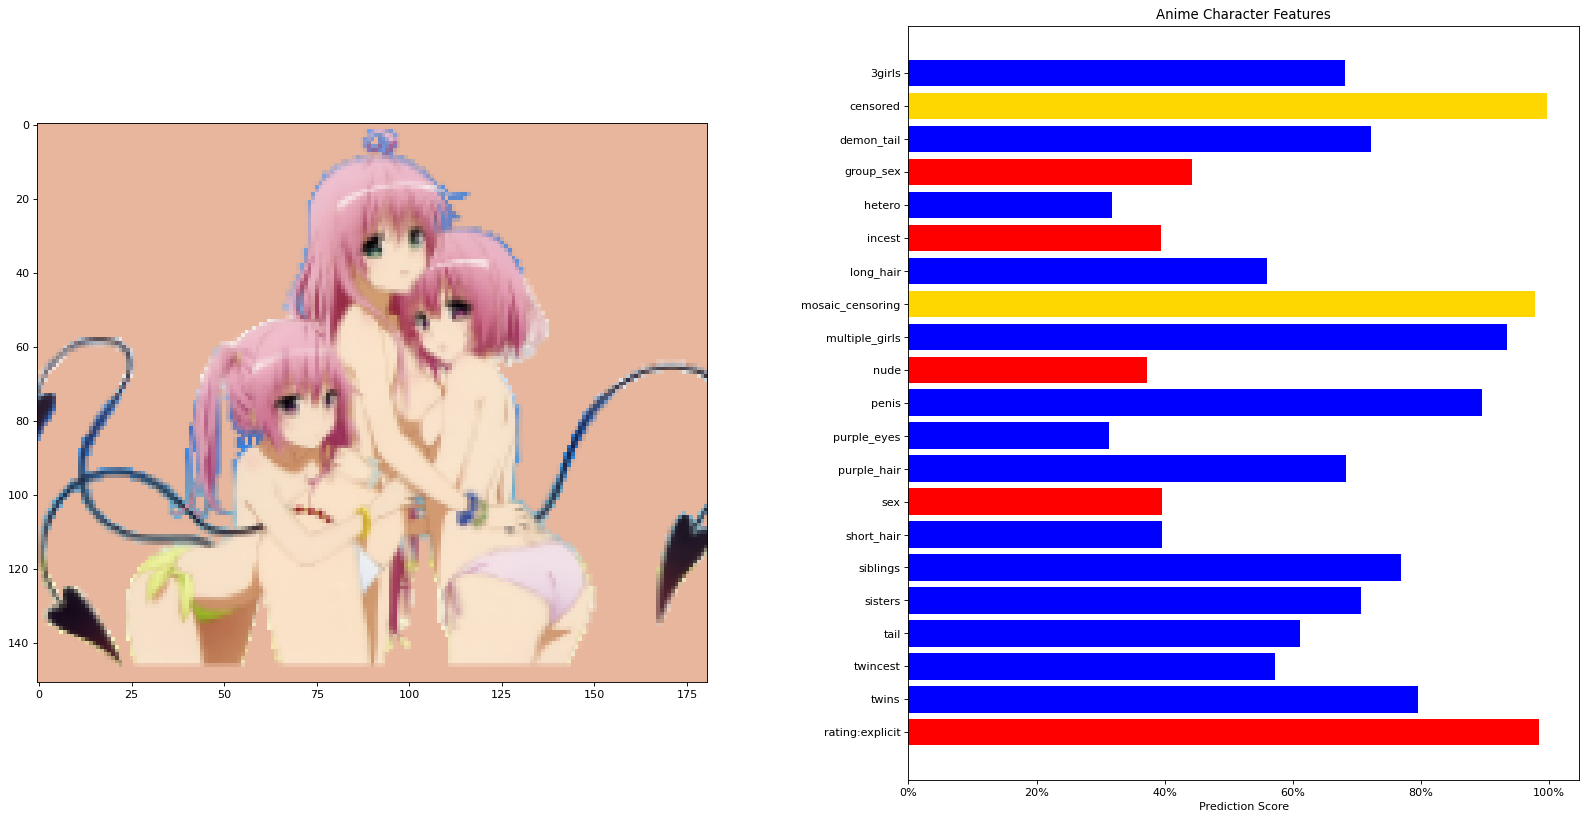

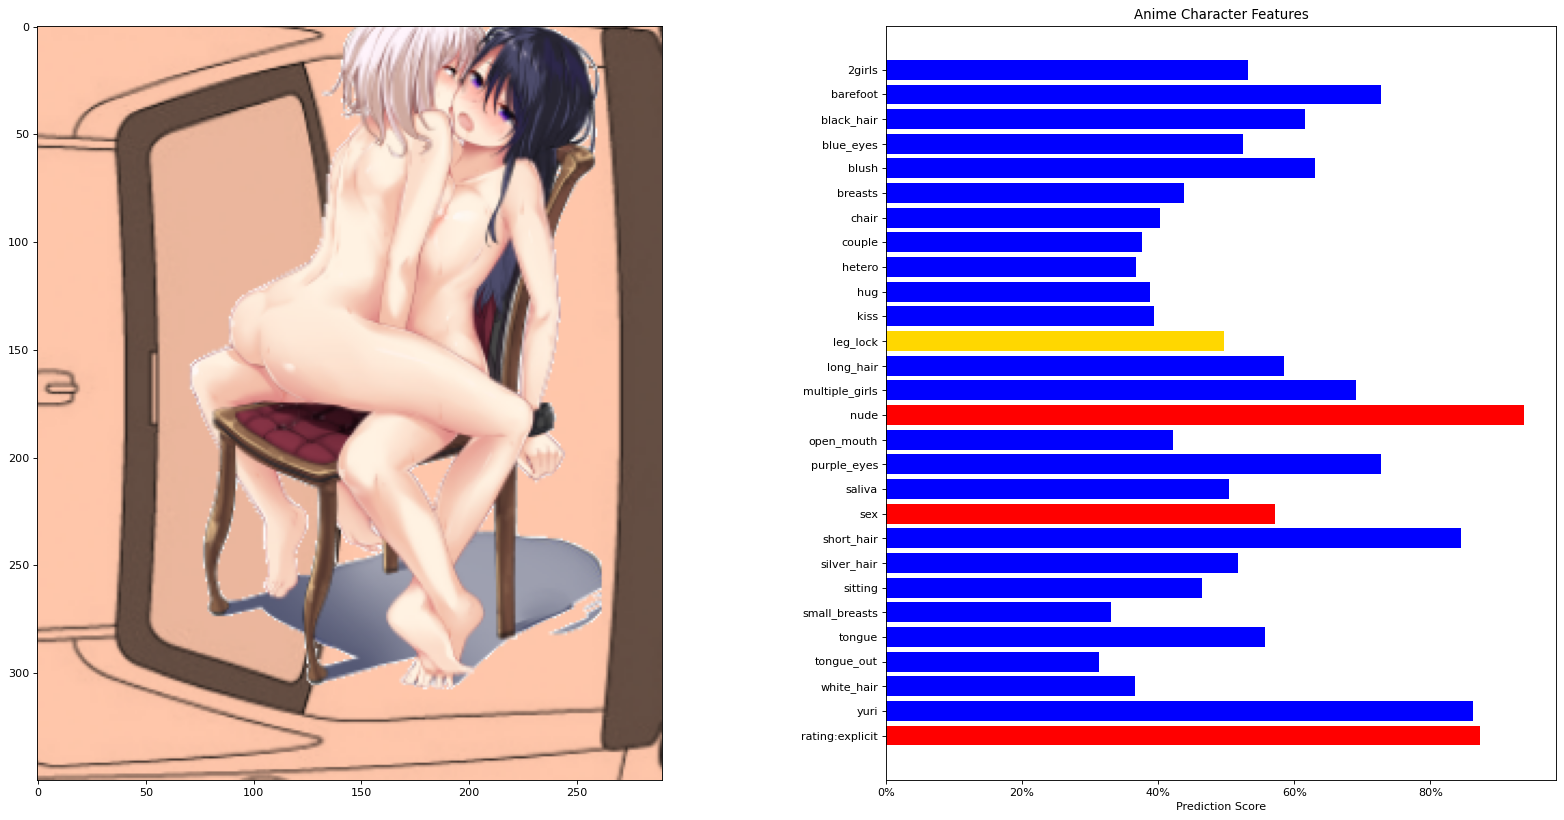

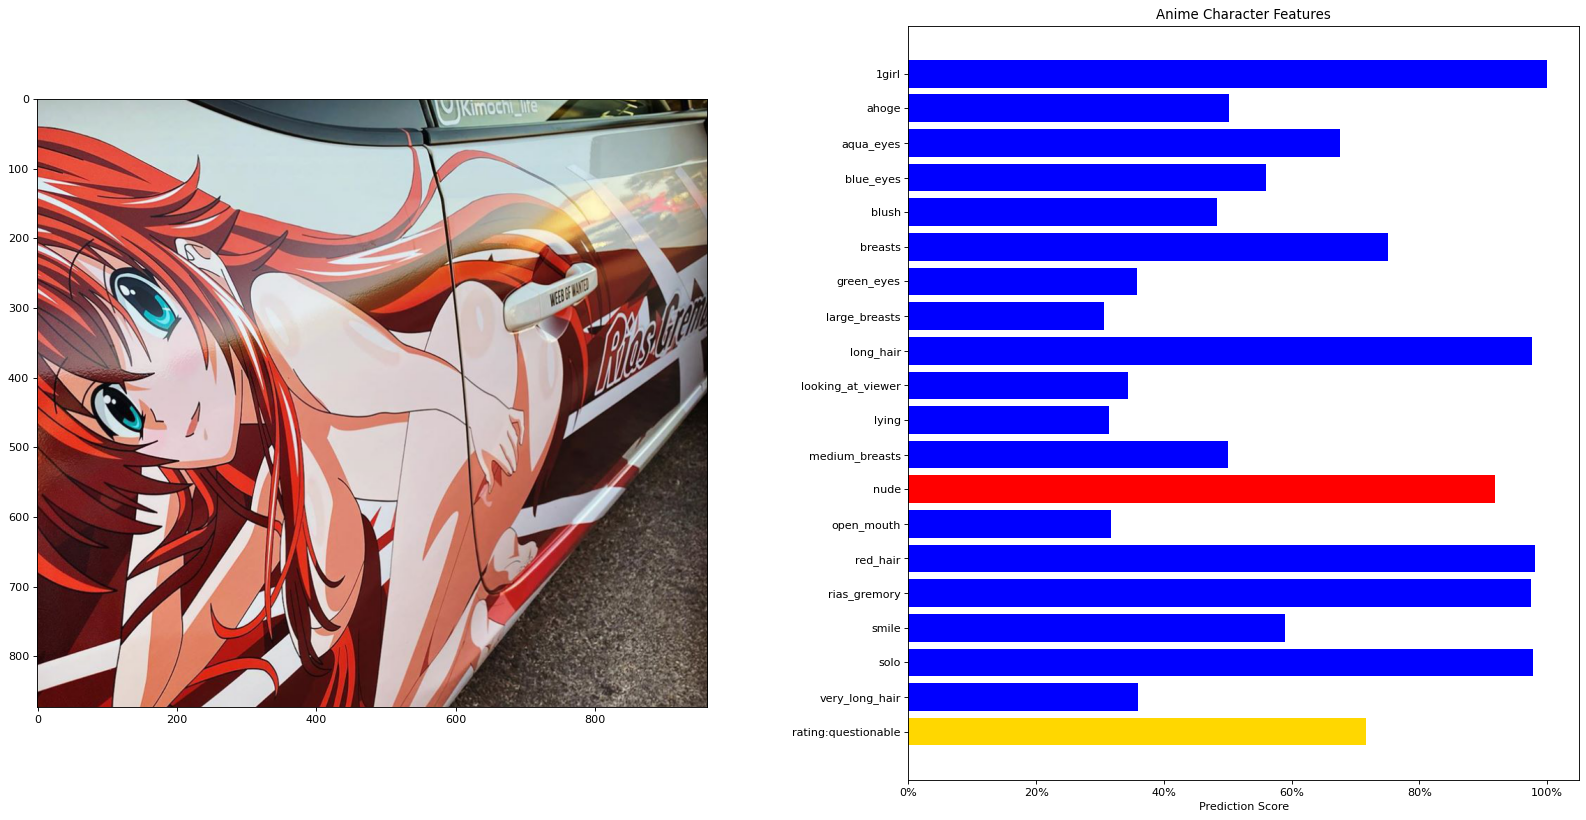

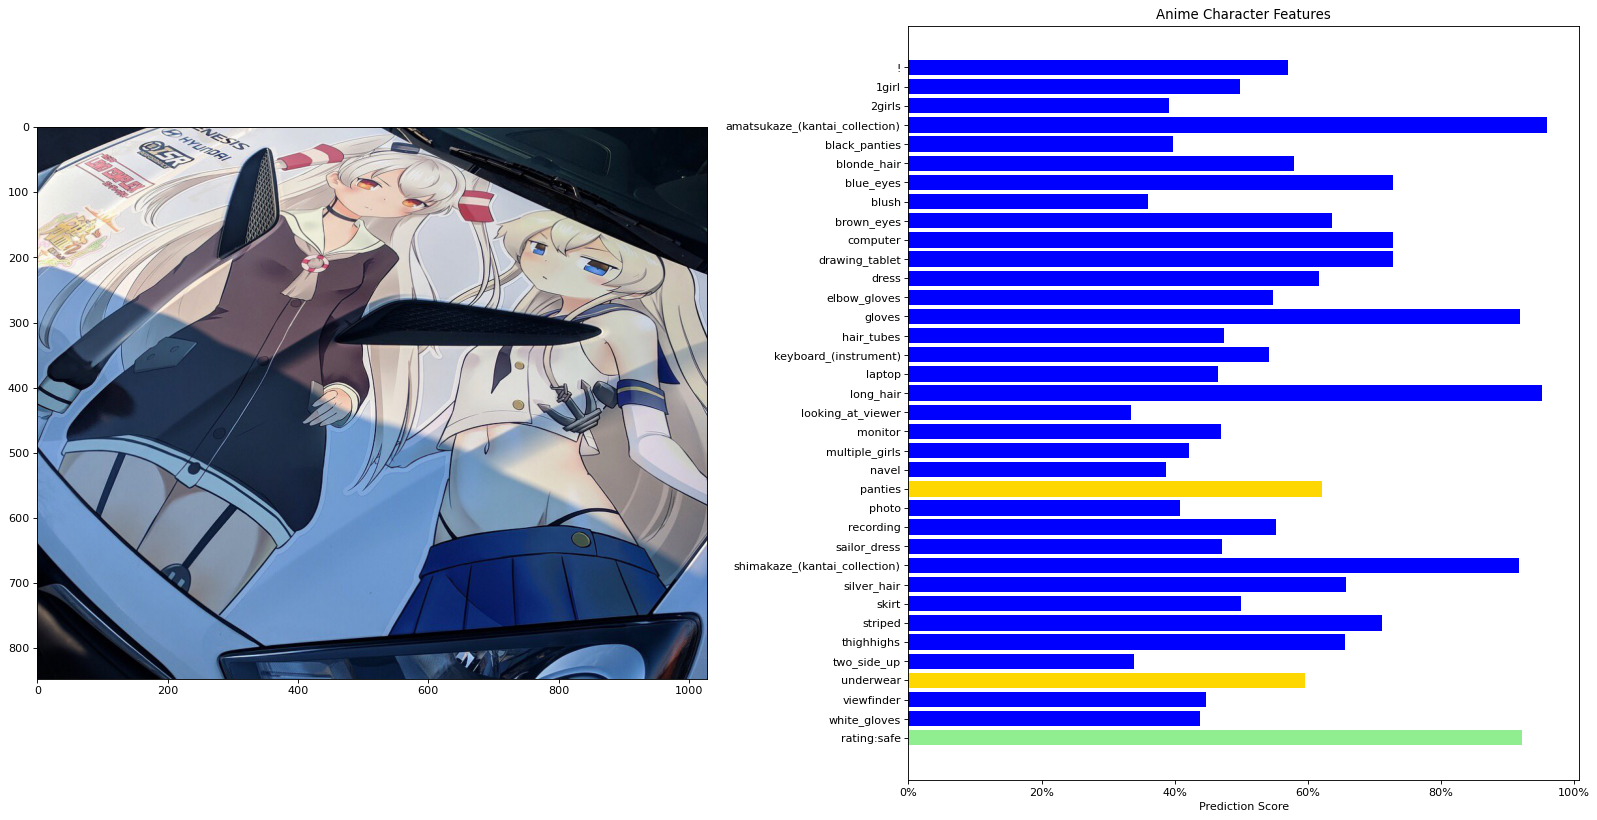

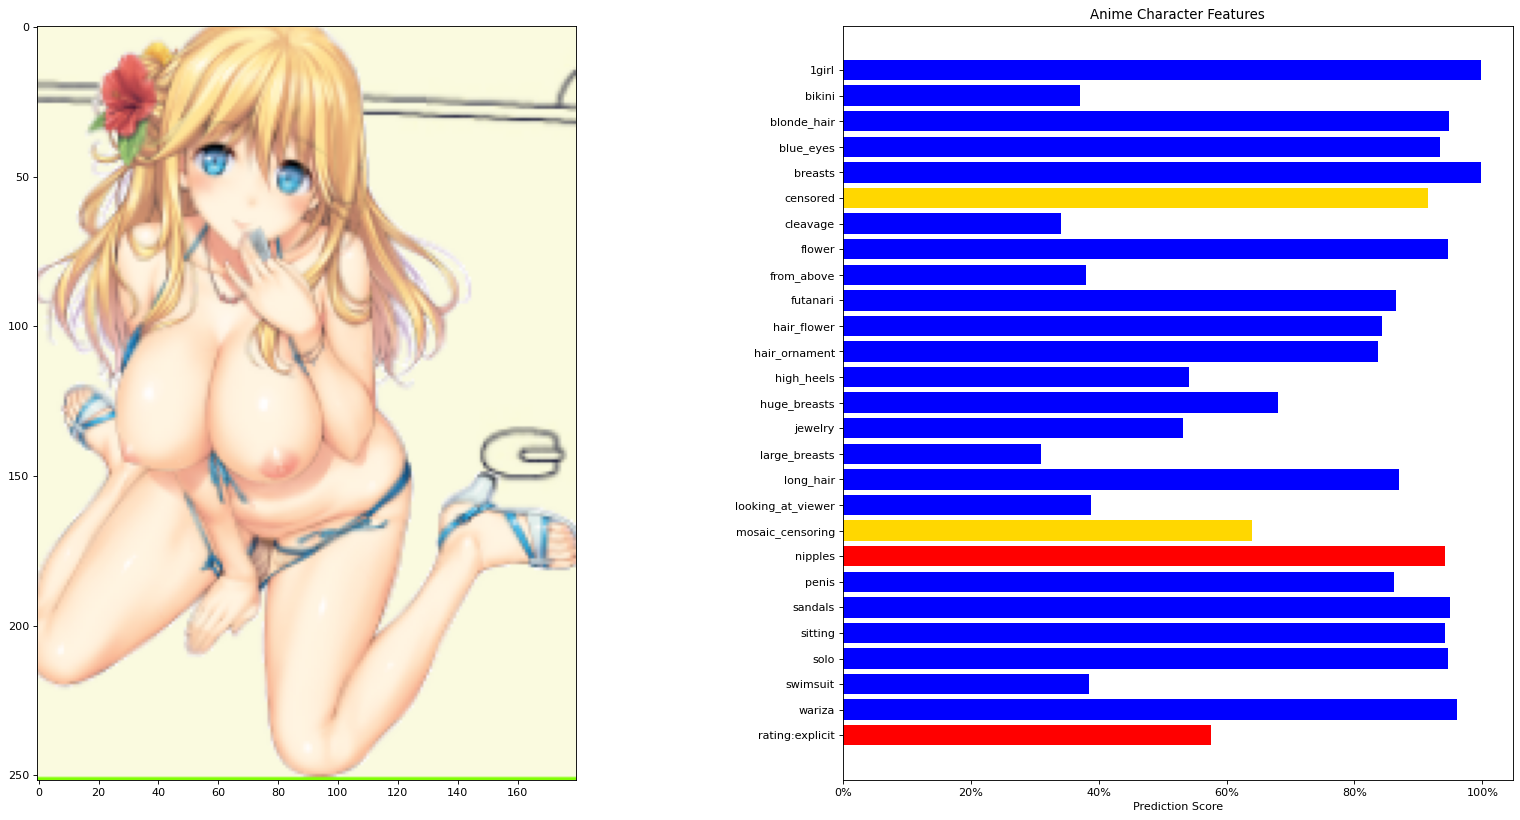

In [200]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick

anime_images_dir = "../../DeepDanbooru/data/tfod/images"
anime_predictions_dir = "../../DeepDanbooru/data/tfod/predictions"
anime_predictions_path = os.path.join(anime_predictions_dir, "predictions.csv")


# Get Images
anime_images = {}
for root, subdir, files in os.walk(anime_images_dir):
    for filename in files:
        img_path = os.path.join(root, filename)
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        print(img.shape)
        anime_images[filename] = img

# Get predictions
anime_predictions = pd.read_csv(anime_predictions_path, sep="\t")
anime_predictions['filename'] = anime_predictions['img_path'].apply(lambda x: os.path.basename(x))

# Plot images with predictions
filter_filename = 'predict_007.png'
img = anime_images[filter_filename]

# Plot Images
n_images = len(anime_images.keys())

tags_red = ['rating:explicit', 'nipples','nude','pubic_hair','pussy','group_sex','incest','sex']
tags_yellow = ['rating:questionable','panties','underwear','censored','mosaic_censoring','leg_lock']
tags_green = ['rating:safe']
# Plot each
for row, (filter_filename, img) in enumerate(anime_images.items()):
    print("====== {}".format(filter_filename))
    row = 1
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), dpi= 80)

    df = anime_predictions[anime_predictions.filename == filter_filename]

    fig.tight_layout(w_pad=15.0)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA), origin='upper')

    # Plot Tags
    df = df.sort_values(['tag'])
    
    # Get rating
    rating = df[df.tag.str.contains("rating")]
    df = df[~df.tag.str.contains("rating")]
    scores = [score * 100 for score in df.score.tolist()]
    tags = df.tag.tolist()
    if rating.shape[0]:
        rating_tag = rating.tag.values[0]
        rating_score = rating.score.values[0]
        scores.append(rating_score * 100)
        tags.append(rating_tag)
        y_pos = list(range(df.shape[0] + 1))
    else:
        
        y_pos = list(range(df.shape[0]))
    
    colors = []
    for tag in tags:
        if tag in tags_red:
            colors.append("red")
        elif tag in tags_green:
            colors.append("lightgreen")
        elif tag in tags_yellow:
            colors.append("gold")
        else:
            colors.append("blue")
    
    
    axs[1].barh(y_pos, scores, align='center', color=colors)
    axs[1].set_yticks(y_pos)
    axs[1].set_yticklabels(tags)
    axs[1].invert_yaxis()  # labels read top-to-bottom
    axs[1].set_xlabel('Prediction Score')
    axs[1].set_title('Anime Character Features')
    axs[1].xaxis.set_major_formatter(mtick.PercentFormatter())

    plt.savefig(os.path.join(anime_predictions_dir, filter_filename))

In [175]:
df = anime_predictions[anime_predictions.filename == filter_filename]
print(filter_filename)
print(df.shape)

# Get rating
rating = df[df.tag.str.contains("rating")]


rating_tag = rating.tag.values[0]
rating_score = rating.score.values[0]
df = df[~df.tag.str.contains("rating")]

scores =  * 100
print(df.score.tolist())
scores.append(rating_score)

predict_007.png
(29, 4)
[0.97214913, 0.3593582, 0.34185174, 0.56944776, 0.9983770000000001, 0.87585247, 0.75304675, 0.98085225, 0.72462237, 0.9286375, 0.6478921999999999, 0.74587595, 0.64740187, 0.9869474, 0.98250806, 0.86445594, 0.47637075, 0.5278107, 0.6743889, 0.32541615, 0.86725056, 0.48515505, 0.84157443, 0.8189126999999999, 0.96012104, 0.9977351000000001, 0.38364008, 0.9998065]
